# Exploratory Data Analysis

In [1]:
import os
import time
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision import transforms
from collections import defaultdict
from torchvision.datasets.folder import pil_loader
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
from skimage import io, transform

pd.set_option('max_colwidth', 800)

%matplotlib inline

## Load Data

We have seven categories of musculoskeletal radiographs

In [2]:
import pandas as pd

# Reading paths and labels for training data
train_paths_df = pd.read_csv(r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\train_image_paths.csv', names=['Path'])
train_labels_df = pd.read_csv(r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\train_labeled_studies.csv', names=['Label'])

# Reset indexes to ensure proper alignment
train_paths_df.reset_index(drop=True, inplace=True)
train_labels_df.reset_index(drop=True, inplace=True)

# Concatenate paths and labels into a single DataFrame for training data
train_df = pd.concat([train_paths_df, train_labels_df], axis=1)

# Check for NaN values in train_df
print("NaN values in train_df:")
print(train_df.isna().sum())

# Reading paths and labels for validation data
valid_paths_df = pd.read_csv(r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\valid_image_paths.csv', names=['Path'])
valid_labels_df = pd.read_csv(r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\train_labeled_studies.csv', names=['Label'])

# Reset indexes to ensure proper alignment
valid_paths_df.reset_index(drop=True, inplace=True)
valid_labels_df.reset_index(drop=True, inplace=True)

# Concatenate paths and labels into a single DataFrame for validation data
valid_df = pd.concat([valid_paths_df, valid_labels_df], axis=1)

# Check for NaN values in valid_df
print("\nNaN values in valid_df:")
print(valid_df.isna().sum())



NaN values in train_df:
Path         0
Label    23351
dtype: int64

NaN values in valid_df:
Path     10260
Label        0
dtype: int64


In [3]:
valid_paths_df.shape,valid_labels_df.shape


((3197, 1), (13457, 1))

In [4]:
# Drop rows with NaN values in the 'Label' column
train_df.dropna(subset=['Label'], inplace=True)
valid_df.dropna(subset=['Label'],inplace=True)
valid_df.dropna(subset=['Path'],inplace=True)
print(train_df.isna().sum())
print(valid_df.isna().sum())


Path     0
Label    0
dtype: int64
Path     0
Label    0
dtype: int64


In [5]:
# Drop rows with NaN values in the 'Label' column
train_df.dropna(subset=['Label'], inplace=True)
valid_df.dropna(subset=['Label'],inplace=True)
print(train_df.isna().sum())
print(valid_df.isna().sum())


Path     0
Label    0
dtype: int64
Path     0
Label    0
dtype: int64


Let's checkout the shapes of dataframes

In [6]:
train_df.shape, valid_df.shape

((13457, 2), (3197, 2))

We have 37111 radiographs for training and 3225 radiographs for validation set, let's peak into the dataframes

In [7]:
train_df.head(3)

,Path,Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,1.0
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,1.0
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,1.0


In [8]:
valid_df.head(3)

,Path,Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,1


So, we have radiograph paths and their correspoinding labels, each radiographs has a label of 0 (normal) or 1 (abnormal)

## Analysis

According to paper: <br>
1.

    The MURA abnormality detection task is a binary classification task, where the input is an upper 
    exremity radiograph study — with each study containing one or more views (images) — and the 
    expected output is a binary label y ∈ {0, 1} indicating whether the "study" is normal or abnormal, 
    respectively.
2.

    The model takes as input one or more views for a study of an upper extremity. On each view, our 169-
    layer convolutional neural network predicts the probability of abnormality. We compute the overall 
    probability of abnormality for the study by taking the arithmetic mean of the abnormality 
    probabilities output by the network for each image. The model makes the binary prediction of 
    abnormal if the probability of abnormality for the study is greater than 0.5.

So, we have make predictions on study level, taking into account the predictions of all the views (images) of the study. This can be done by taking arithmetic mean of all the views (images) under a particular study.

In [9]:
train_df.head(30)

,Path,Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,1.0
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,1.0
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,1.0
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,1.0
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,1.0
5,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image3.png,1.0
6,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image1.png,1.0
7,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image2.png,0.0
8,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image3.png,1.0
9,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/image1.png,1.0


Analyzing this dataframe, we can see that images are annotated based on whether their corresponding study is positive (normal, 0) or negative (abnormal, 1)

In [10]:
valid_df

,Path,Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,1
...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image3.png,0
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image4.png,0
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image1.png,0
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image2.png,0


### Plot some random radiographs from training and validation set

In [11]:
train_mat = train_df.values
valid_mat = valid_df.values

print(valid_mat)


[['MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png' 1]
 ['MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png' 1]
 ['MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png' 1]
 ...
 ['MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image1.png' 0]
 ['MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image2.png' 0]
 ['MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image3.png' 0]]


In [12]:
# Drop rows with NaN values in the 'Label' column
train_df.dropna(subset=['Label'], inplace=True)
valid_df.dropna(subset=['Label'],inplace=True)
print(train_df.isna().sum())
print(valid_df.isna().sum())

Path     0
Label    0
dtype: int64
Path     0
Label    0
dtype: int64


[[[23 23 23]
  [26 26 26]
  [11 11 11]
  ...
  [ 8  8  8]
  [ 8  8  8]
  [ 9  9  9]]

 [[25 25 25]
  [ 9  9  9]
  [ 7  7  7]
  ...
  [ 7  7  7]
  [ 7  7  7]
  [ 7  7  7]]

 [[ 8  8  8]
  [ 6  6  6]
  [ 8  8  8]
  ...
  [ 6  6  6]
  [ 6  6  6]
  [ 7  7  7]]

 ...

 [[ 8  8  8]
  [ 8  8  8]
  [ 9  9  9]
  ...
  [ 4  4  4]
  [ 4  4  4]
  [ 4  4  4]]

 [[ 7  7  7]
  [ 8  8  8]
  [ 8  8  8]
  ...
  [ 4  4  4]
  [ 4  4  4]
  [ 4  4  4]]

 [[ 8  8  8]
  [ 7  7  7]
  [ 7  7  7]
  ...
  [ 3  3  3]
  [ 3  3  3]
  [ 3  3  3]]]


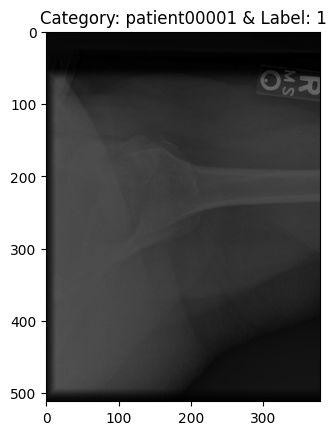

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

# Randomly select an index within the range of the length of train_mat
ix = np.random.randint(0, len(train_mat))

# Extract the image path using the randomly selected index
img_path = r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\train\XR_SHOULDER\patient00001\study1_positive\image1.png'
# Display the image using Matplotlib
try:
    img = io.imread(img_path)
    print(img)
    plt.imshow(img, cmap='binary')

    # Extract the radiograph category from the image path
    cat = img_path.split(os.sep)[-3]

    # Get the label from train_mat corresponding to the randomly selected index
    label = train_mat[ix][1]

    # Set the title of the plot with the radiograph category and label
    plt.title('Category: %s & Label: %d' % (cat, label))

    # Show the plot
    plt.show()
except Exception as e:
    print("Error occurred:", e)


IndexError: list index out of range

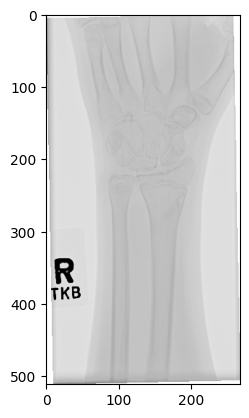

In [14]:

img_path = r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\valid\XR_WRIST\patient11185\study1_positive\image1.png'
plt.imshow(io.imread(img_path), cmap='binary')
cat = img_path.split('/')[2]
plt.title('Category: %s & Lable: %d ' %(cat, valid_mat[ix][1]))
plt.show()

This can be seen that images vary in resolution and dimension

In [15]:
# look at the pixel values
io.imread(img_path)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Data Exploration

In [16]:
import os

train_path = r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\train'
directory = os.path.join(train_path)
print(os.listdir(directory))

['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']


In [17]:
import os

train_path = r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\train'
directory = os.path.join(train_path, 'XR_ELBOW')
print(os.listdir(directory))

['patient00011', 'patient00016', 'patient00026', 'patient00031', 'patient00034', 'patient00044', 'patient00069', 'patient00147', 'patient00148', 'patient00164', 'patient00180', 'patient00196', 'patient00222', 'patient00238', 'patient00266', 'patient00280', 'patient00310', 'patient00328', 'patient00354', 'patient00357', 'patient00370', 'patient00374', 'patient00377', 'patient00380', 'patient00398', 'patient00401', 'patient00404', 'patient00427', 'patient00434', 'patient00463', 'patient00466', 'patient00511', 'patient00537', 'patient00562', 'patient00643', 'patient00646', 'patient00665', 'patient00673', 'patient00707', 'patient00737', 'patient00745', 'patient00821', 'patient00876', 'patient00894', 'patient00901', 'patient00905', 'patient00918', 'patient00936', 'patient00956', 'patient00982', 'patient00990', 'patient01005', 'patient01055', 'patient01057', 'patient01079', 'patient01112', 'patient01114', 'patient01130', 'patient01134', 'patient01145', 'patient01157', 'patient01164', 'patien

So, train dataset has seven study types, each study type has studies on patients stored in folders named like patient001, patient002 etc..

#### Patient count per study type

Let's count number of patients in each study type

In [18]:
import os

train_path = r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\train'
valid_path = r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\valid'

study_types = list(os.walk(train_path))[0][1]  # study types, same for train and valid sets
patients_count = {}  # to store all patients count for each study type, for train and valid sets

for phase in ['train', 'valid']:
    patients_count[phase] = {}
    for study_type in study_types:
        patients = list(os.walk(f'{train_path if phase == "train" else valid_path}/{study_type}'))[0][1]  # patient folder names
        patients_count[phase][study_type] = len(patients)

print(patients_count)

{'train': {'XR_ELBOW': 1711, 'XR_FINGER': 1865, 'XR_FOREARM': 865, 'XR_HAND': 1945, 'XR_HUMERUS': 587, 'XR_SHOULDER': 2317, 'XR_WRIST': 3267}, 'valid': {'XR_ELBOW': 152, 'XR_FINGER': 67, 'XR_FOREARM': 129, 'XR_HAND': 159, 'XR_HUMERUS': 132, 'XR_SHOULDER': 173, 'XR_WRIST': 207}}


In [19]:
print(study_types)
print()
print(patients_count)

['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']

{'train': {'XR_ELBOW': 1711, 'XR_FINGER': 1865, 'XR_FOREARM': 865, 'XR_HAND': 1945, 'XR_HUMERUS': 587, 'XR_SHOULDER': 2317, 'XR_WRIST': 3267}, 'valid': {'XR_ELBOW': 152, 'XR_FINGER': 67, 'XR_FOREARM': 129, 'XR_HAND': 159, 'XR_HUMERUS': 132, 'XR_SHOULDER': 173, 'XR_WRIST': 207}}


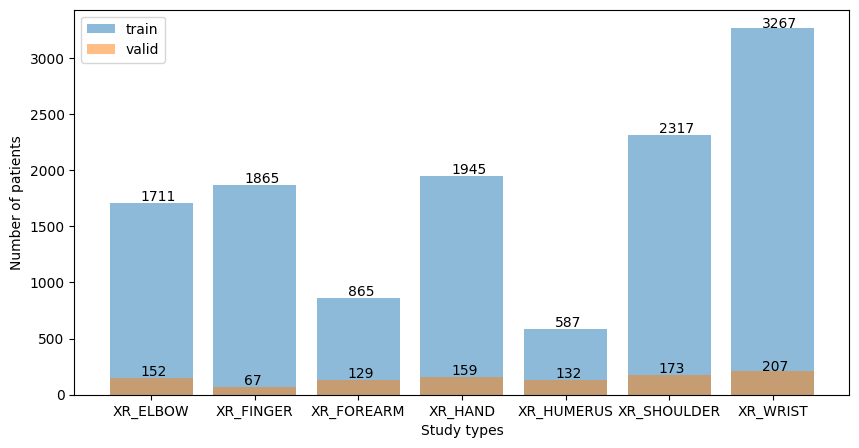

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\kumar govind\\Downloads\\images\\pcpst.jpg'

In [25]:
# plot the patient counts per study type 
data_cat = ['train', 'valid']
fig, ax = plt.subplots(figsize=(10, 5))
for i, phase in enumerate(data_cat):
    counts = patients_count[phase].values()
    m = max(counts)
    for i, v in enumerate(counts):
        if v==m: ax.text(i-0.1, v+3, str(v))
        else: ax.text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    plt.bar(x_pos, counts, alpha=0.5)
    plt.xticks(x_pos, study_types)

plt.xlabel('Study types')
plt.ylabel('Number of patients')
plt.legend(['train', 'valid'])
plt.show()
fig.savefig('images/pcpst.jpg', bbox_inches='tight', pad_inches=0) # name=patient count per study type

XR_FINGER has got the most number of patients (1867 in train set, 166 in valid set) followed by XR_WRIST

### Study count

Patients might have multiple studies for a given study type, like a patient may have two studies for wrist, independent of each other. <br> Let's have a look at such cases, **NOTE** here study count = number of patients which have same number of studies

In [21]:
# let's find out number of studies per study_type
study_count = {} # to store study counts for each study type 
for study_type in study_types:
    BASE_DIR = r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\train/%s/' % study_type
    study_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR+patient)
        study_count[study_type][len(studies)] += 1

In [22]:
study_count

{'XR_ELBOW': defaultdict(<function __main__.<lambda>()>,
             {1: 1669, 3: 1, 2: 41}),
 'XR_FINGER': defaultdict(<function __main__.<lambda>()>,
             {1: 1799, 2: 62, 3: 4}),
 'XR_FOREARM': defaultdict(<function __main__.<lambda>()>, {1: 853, 2: 12}),
 'XR_HAND': defaultdict(<function __main__.<lambda>()>,
             {1: 1875, 2: 67, 3: 3}),
 'XR_HUMERUS': defaultdict(<function __main__.<lambda>()>, {1: 582, 2: 5}),
 'XR_SHOULDER': defaultdict(<function __main__.<lambda>()>,
             {1: 2221, 2: 87, 4: 4, 3: 5}),
 'XR_WRIST': defaultdict(<function __main__.<lambda>()>,
             {1: 3094, 2: 157, 3: 12, 4: 4})}

XR_WRIST has 3111 patients who have only single study, similarly, 158 patients have 2 studies, 12 patients have 3 studies and 4 patients have 4 studies. <br> let's plot this data

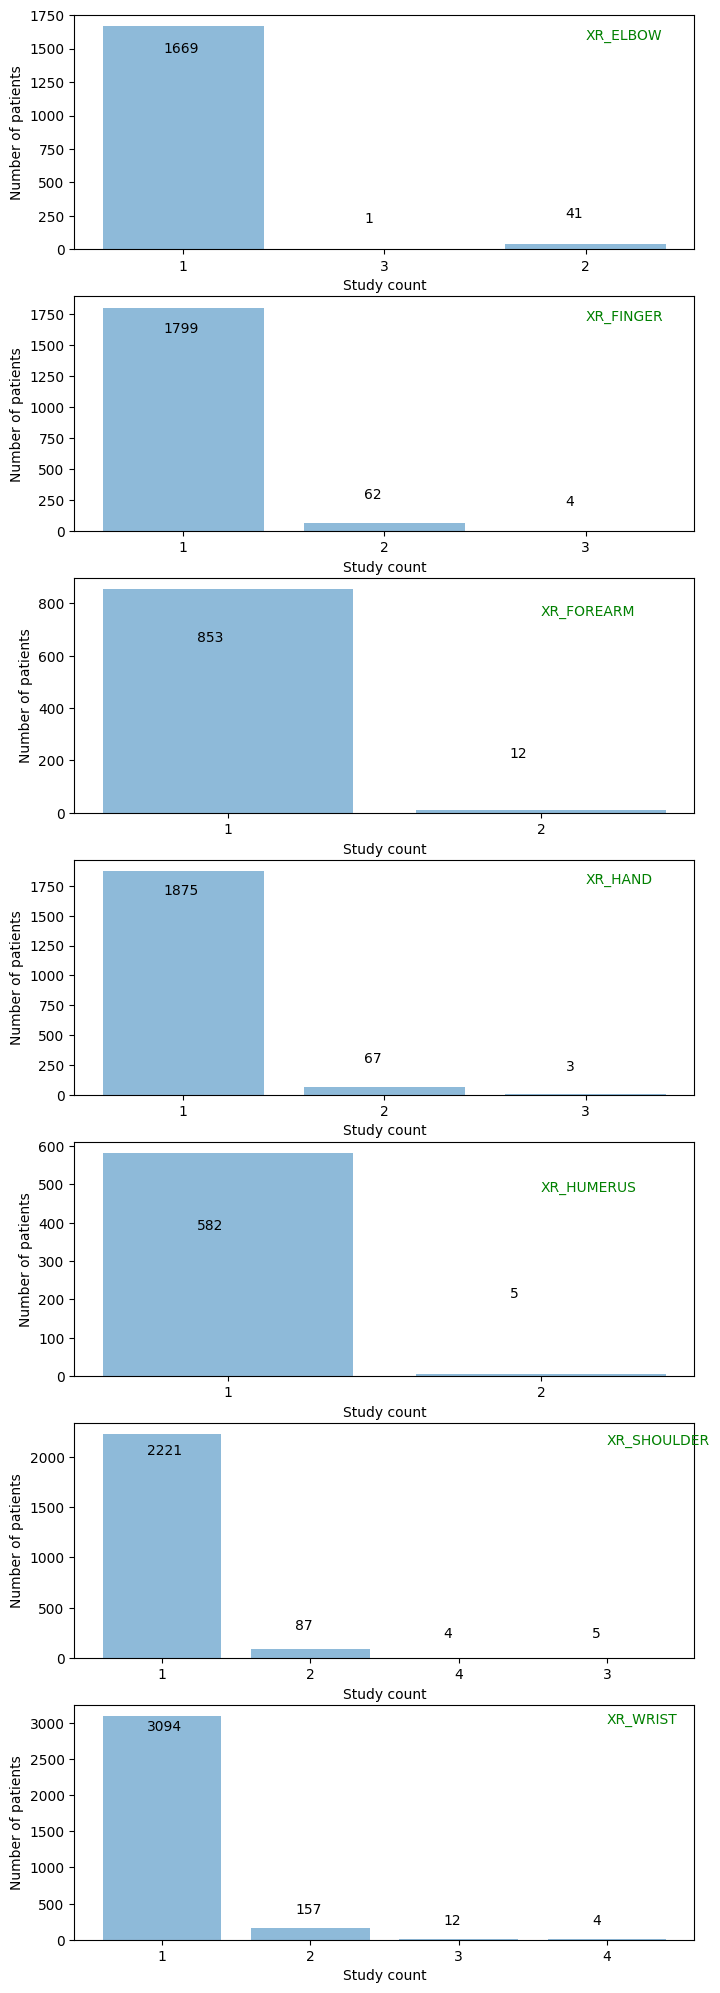

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\kumar govind\\Downloads\\images\\pcpsc.jpg'

In [23]:
# plot the study count vs number of patients per study type data 
fig = plt.figure(figsize=(8, 25))
for i, study_type in enumerate(study_count):
    ax = fig.add_subplot(7, 1, i+1)
    study = study_count[study_type]
    # text in the plot
    m = max(study.values())
    for i, v in enumerate(study.values()):
        if v==m: ax.text(i-0.1, v - 200, str(v))
        else: ax.text(i-0.1, v + 200, str(v))
    ax.text(i, m - 100, study_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(study))
    plt.bar(x_pos, study.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  study.keys())
    plt.xlabel('Study count')
    plt.ylabel('Number of patients')
plt.show()
fig.savefig('images/pcpsc.jpg', bbox_inches='tight', pad_inches=0)

### Number of views per study

It can be seen that each study may have more that one view (radiograph image), let' have a look

In [ ]:
# let's find out number of studies per study_type
view_count = {} # to store study counts for each study type, study count = number of patients which have similar number of studies 
for study_type in study_types:
    BASE_DIR = r'C:\Users\kumar govind\Downloads\Ml\nlp\MURA-v1.1\train/%s/' % study_type
    view_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR + patient)
        for study in studies:
            views = os.listdir(BASE_DIR + patient + '/' + study)
            view_count[study_type][len(views)] += 1

In [ ]:
view_count

{'XR_ELBOW': defaultdict(<function __main__.<lambda>()>,
             {3: 638, 2: 724, 4: 275, 5: 65, 1: 35, 6: 10, 7: 7}),
 'XR_FINGER': defaultdict(<function __main__.<lambda>()>,
             {1: 359, 3: 1261, 2: 160, 4: 132, 5: 22, 6: 1}),
 'XR_FOREARM': defaultdict(<function __main__.<lambda>()>,
             {2: 669, 3: 92, 1: 87, 4: 23, 5: 5, 7: 1}),
 'XR_HAND': defaultdict(<function __main__.<lambda>()>,
             {3: 1404, 2: 517, 4: 60, 1: 32, 5: 5}),
 'XR_HUMERUS': defaultdict(<function __main__.<lambda>()>,
             {2: 487, 3: 62, 1: 22, 4: 16, 6: 1, 5: 4}),
 'XR_SHOULDER': defaultdict(<function __main__.<lambda>()>,
             {3: 868, 4: 775, 1: 276, 2: 441, 5: 60, 6: 5, 11: 1}),
 'XR_WRIST': defaultdict(<function __main__.<lambda>()>,
             {3: 2004, 4: 477, 2: 662, 1: 275, 6: 11, 5: 24, 7: 5, 8: 2})}

`XR_SHOULDER` has as many as 13 views in some studies, `XR_HAND` has 5 at max, this poses a challenging task to predict on a study taking into account all the views of that study while keeping the batch size of 8 (as mentioned in MURA paper)

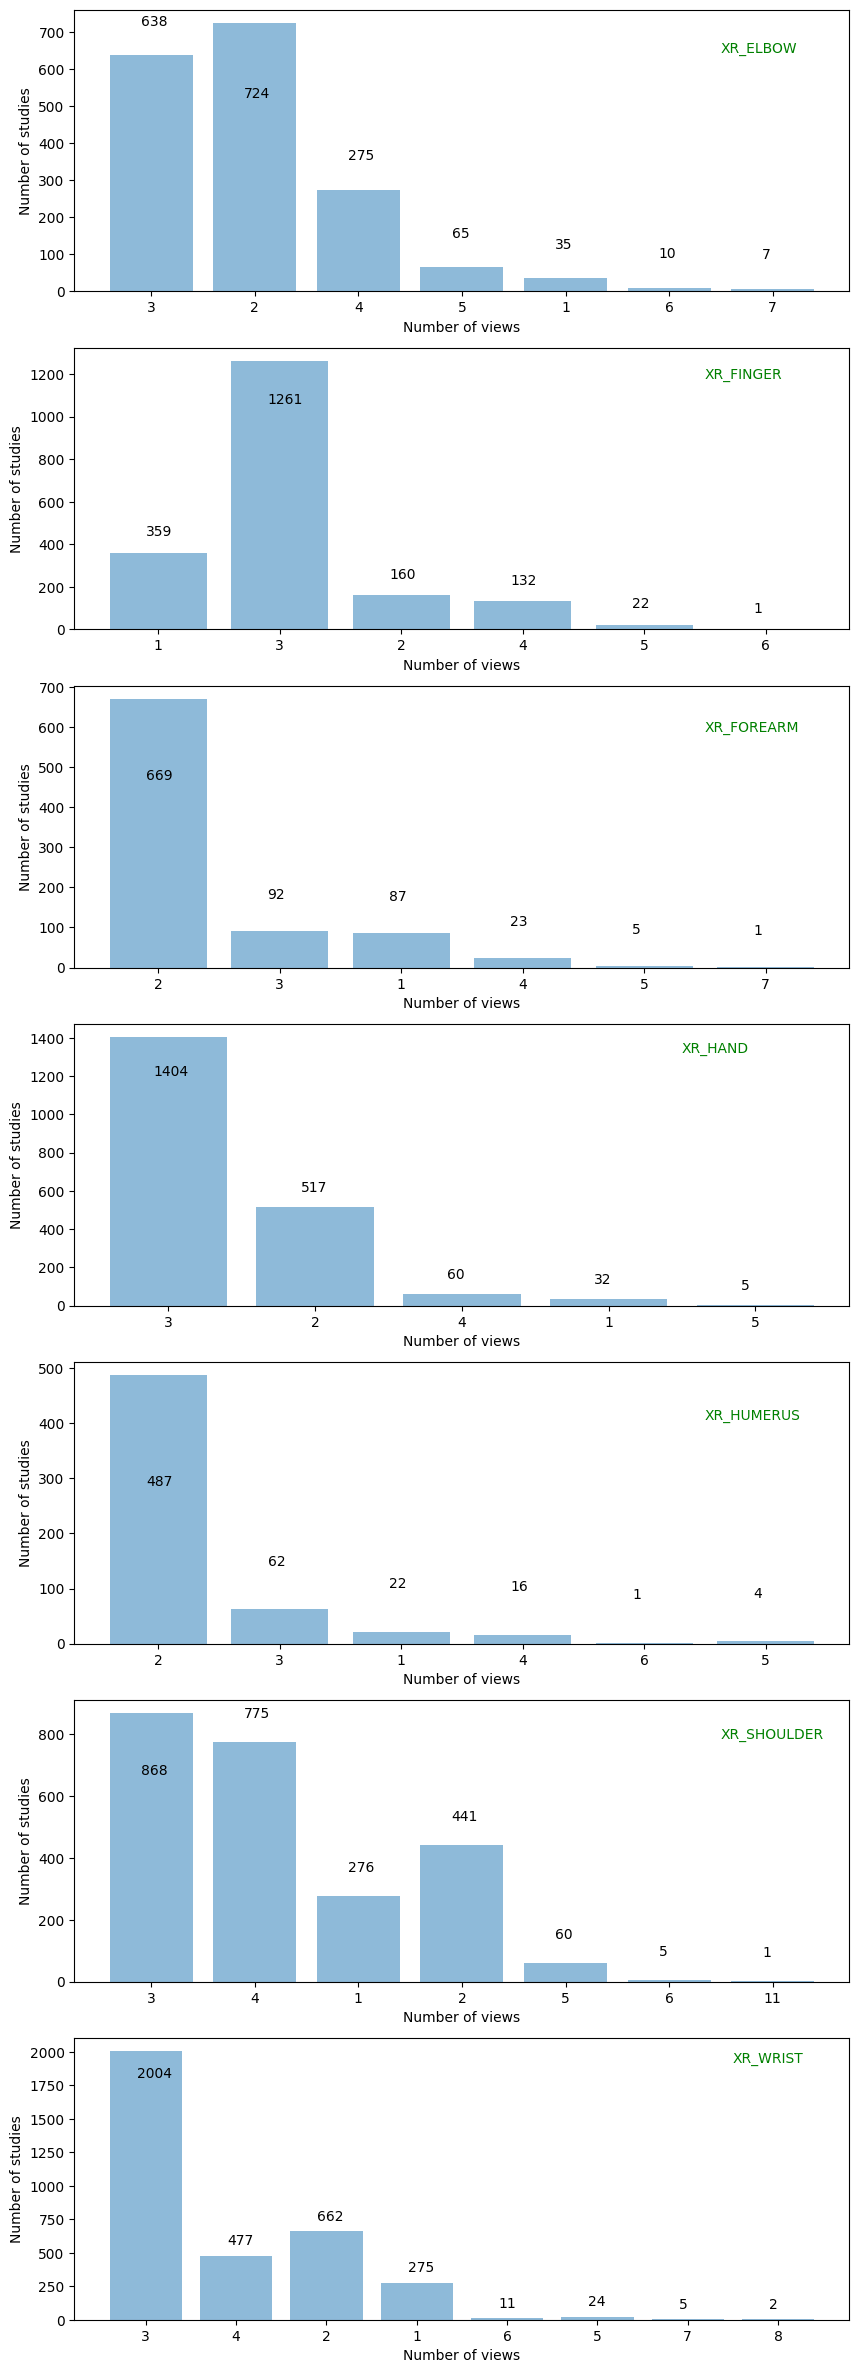

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\kumar govind\\Downloads\\images\\nsvc.jpg'

In [ ]:
# plot the view count vs number of studies per study type data 
fig = plt.figure(figsize=(10, 30))
for i, view_type in enumerate(view_count):
    ax = fig.add_subplot(7, 1, i+1)
    view = view_count[view_type]
    # text in the plot
    m = max(view.values())
    for i, v in enumerate(view.values()):
        if v==m: ax.text(i-0.1, v - 200, str(v))
        else: ax.text(i-0.1, v + 80, str(v))
    ax.text(i - 0.5, m - 80, view_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(view))
    plt.bar(x_pos, view.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  view.keys())
    plt.xlabel('Number of views')
    plt.ylabel('Number of studies')
plt.show()
fig.savefig('images/nsvc.jpg', bbox_inches='tight', pad_inches=0) # name=number of studies view count

Most of the studies contain 2, 3 or 4 views